In [44]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,classification_report,roc_curve,roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Attribute Information:

1. One of {+/-}, indicating the class ("+" = promoter).
2. The instance name (non-promoters named by position in the 1500-long nucleotide sequence provided by T. Record).
3-59. The remaining 57 fields are the sequence, starting at position -50 (p-50) and ending at position +7 (p7). Each of these fields is filled by one of {a, g, t, c}

In [45]:
# Molecular Biology (Promoter Gene Sequences) Data Set from UCI
#  E. Coli promoter gene sequences (DNA) with partial domain theory

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data"

df = pd.read_csv(url, sep=",|\t",names=['class', 'instance_name', 'col_1', 'col_2', 'gene_sequence'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [46]:
display(df.shape)
display(df.info())
df.head(10)

(106, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   class          106 non-null    object 
 1   instance_name  106 non-null    object 
 2   col_1          0 non-null      float64
 3   col_2          25 non-null     object 
 4   gene_sequence  81 non-null     object 
dtypes: float64(1), object(4)
memory usage: 4.3+ KB


None

,class,instance_name,col_1,col_2,gene_sequence
0,+,S10,NaN,NaN,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,NaN,NaN,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2,+,AROH,NaN,NaN,gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3,+,DEOP2,NaN,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,None
4,+,LEU1_TRNA,NaN,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,None
5,+,MALEFG,NaN,aggggcaaggaggatggaaagaggttgccgtataaagaaactagag...,None
6,+,MALK,NaN,NaN,cagggggtggaggatttaagccatctcctgatgacgcatagtcagc...
7,+,RECA,NaN,NaN,tttctacaaaacacttgatactgtatgagcatacagtataattgct...
8,+,RPOB,NaN,NaN,cgacttaatatactgcgacaggacgtccgttctgtgtaaatcgcaa...
9,+,RRNAB_P1,NaN,ttttaaatttcctcttgtcaggccggaataactccctataatgcgc...,None


In [47]:
display(df.isna().any())
df['class'].value_counts()

class            False
instance_name    False
col_1             True
col_2             True
gene_sequence     True
dtype: bool

-    53
+    53
Name: class, dtype: int64

In [48]:
df.drop('col_1', axis=1, inplace=True)
df['gene_sequence'] = df['gene_sequence'].combine_first(df['col_2'])
df.drop('col_2', axis=1, inplace=True)
df.head(10)

,class,instance_name,gene_sequence
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
5,+,MALEFG,aggggcaaggaggatggaaagaggttgccgtataaagaaactagag...
6,+,MALK,cagggggtggaggatttaagccatctcctgatgacgcatagtcagc...
7,+,RECA,tttctacaaaacacttgatactgtatgagcatacagtataattgct...
8,+,RPOB,cgacttaatatactgcgacaggacgtccgttctgtgtaaatcgcaa...
9,+,RRNAB_P1,ttttaaatttcctcttgtcaggccggaataactccctataatgcgc...


In [49]:
df = df.replace(to_replace='+', value=1)  #promoter
df = df.replace(to_replace='-', value=0)  #non-promoter
df['class'].value_counts()

1    53
0    53
Name: class, dtype: int64

In [50]:
df['gene_sequence'].str.len()

0      57
1      57
2      57
3      57
4      57
       ..
101    57
102    57
103    57
104    57
105    57
Name: gene_sequence, Length: 106, dtype: int64

# Models using Bag of words:

Using kmer, count vectorizer to fit test data on three classification models:
1. Decision Tree
2. Random Forest
3. Multinomial NB



### K-mer solution:

In [51]:
def get_kmer(x,size):
  return [x[i:i+size].lower() for i in range(0,len(x)-size+1)]

In [52]:
df['kmer'] = df['gene_sequence'].apply(lambda x:get_kmer(x,6)) # 6 = size of kmer
df.head()

,class,instance_name,gene_sequence,kmer
0,1,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,"[tactag, actagc, ctagca, tagcaa, agcaat, gcaat..."
1,1,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,"[tgctat, gctatc, ctatcc, tatcct, atcctg, tcctg..."
2,1,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,"[gtacta, tactag, actaga, ctagag, tagaga, agaga..."
3,1,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,"[aattgt, attgtg, ttgtga, tgtgat, gtgatg, tgatg..."
4,1,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,"[tcgata, cgataa, gataat, ataatt, taatta, aatta..."


In [53]:
df['kmer_words'] = df['kmer'].apply(lambda x:' '.join(x))
df.head()

,class,instance_name,gene_sequence,kmer,kmer_words
0,1,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,"[tactag, actagc, ctagca, tagcaa, agcaat, gcaat...",tactag actagc ctagca tagcaa agcaat gcaata caat...
1,1,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,"[tgctat, gctatc, ctatcc, tatcct, atcctg, tcctg...",tgctat gctatc ctatcc tatcct atcctg tcctga cctg...
2,1,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,"[gtacta, tactag, actaga, ctagag, tagaga, agaga...",gtacta tactag actaga ctagag tagaga agagaa gaga...
3,1,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,"[aattgt, attgtg, ttgtga, tgtgat, gtgatg, tgatg...",aattgt attgtg ttgtga tgtgat gtgatg tgatgt gatg...
4,1,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,"[tcgata, cgataa, gataat, ataatt, taatta, aatta...",tcgata cgataa gataat ataatt taatta aattaa atta...


##### test-train split

In [54]:
X = df['kmer_words']
X.head()

0    tactag actagc ctagca tagcaa agcaat gcaata caat...
1    tgctat gctatc ctatcc tatcct atcctg tcctga cctg...
2    gtacta tactag actaga ctagag tagaga agagaa gaga...
3    aattgt attgtg ttgtga tgtgat gtgatg tgatgt gatg...
4    tcgata cgataa gataat ataatt taatta aattaa atta...
Name: kmer_words, dtype: object

In [55]:
y = df['class']
y.value_counts()

1    53
0    53
Name: class, dtype: int64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)
display(len(X_train), len(y_train))
display(len(X_test), len(y_test))

79

79

27

27

In [57]:
cv = CountVectorizer(ngram_range=(4,4))

In [58]:
X_train_bow = cv.fit_transform(X_train)
X_test_bow = cv.transform(X_test)

### Decision tree classifier

In [59]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_bow, y_train)
dtree_pred = dtree.predict(X_test_bow)
print("Accuracy", accuracy_score(dtree_pred, y_test))

Accuracy 0.8888888888888888


In [60]:
cm = confusion_matrix(y_test, dtree_pred)
print(cm)
report = classification_report(y_test, dtree_pred)
print (report)

[[ 9  3]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.83      1.00      0.91        15

    accuracy                           0.89        27
   macro avg       0.92      0.88      0.88        27
weighted avg       0.91      0.89      0.89        27



### Random forest classifier

In [61]:
rf = RandomForestClassifier()
rf.fit(X_train_bow, y_train)
rf_pred = rf.predict(X_test_bow)
print("Accuracy", accuracy_score(rf_pred, y_test))

Accuracy 1.0


In [62]:
cm = confusion_matrix(y_test, rf_pred)
print(cm)
report = classification_report(y_test, rf_pred)
print (report)

[[12  0]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        15

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



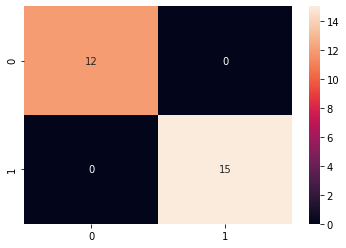

In [63]:
sns.heatmap(cm, annot=True, fmt='g')

### Multinomial Naive Bayes classifier

In [64]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
nb_pred = nb.predict(X_test_bow)
print("Accuracy", accuracy_score(nb_pred, y_test))

Accuracy 0.7777777777777778


In [65]:
cm = confusion_matrix(y_test, nb_pred)
print(cm)
report = classification_report(y_test, nb_pred)
print (report)

[[12  0]
 [ 6  9]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       1.00      0.60      0.75        15

    accuracy                           0.78        27
   macro avg       0.83      0.80      0.77        27
weighted avg       0.85      0.78      0.77        27



# Models using ordinal encoding:
Using ordinal encoding of gene sequence, we fit test data on three classification models:

1. Decision Tree
2. Random Forest
3. Multinomial NB

In [66]:
df.columns

Index(['class', 'instance_name', 'gene_sequence', 'kmer', 'kmer_words'], dtype='object')

In [67]:
# convert dna string to array
df['kmer_list'] = df['gene_sequence'].apply(lambda x:get_kmer(x,1))
df.head()

,class,instance_name,gene_sequence,kmer,kmer_words,kmer_list
0,1,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,"[tactag, actagc, ctagca, tagcaa, agcaat, gcaat...",tactag actagc ctagca tagcaa agcaat gcaata caat...,"[t, a, c, t, a, g, c, a, a, t, a, c, g, c, t, ..."
1,1,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,"[tgctat, gctatc, ctatcc, tatcct, atcctg, tcctg...",tgctat gctatc ctatcc tatcct atcctg tcctga cctg...,"[t, g, c, t, a, t, c, c, t, g, a, c, a, g, t, ..."
2,1,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,"[gtacta, tactag, actaga, ctagag, tagaga, agaga...",gtacta tactag actaga ctagag tagaga agagaa gaga...,"[g, t, a, c, t, a, g, a, g, a, a, c, t, a, g, ..."
3,1,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,"[aattgt, attgtg, ttgtga, tgtgat, gtgatg, tgatg...",aattgt attgtg ttgtga tgtgat gtgatg tgatgt gatg...,"[a, a, t, t, g, t, g, a, t, g, t, g, t, a, t, ..."
4,1,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,"[tcgata, cgataa, gataat, ataatt, taatta, aatta...",tcgata cgataa gataat ataatt taatta aattaa atta...,"[t, c, g, a, t, a, a, t, t, a, a, c, t, a, t, ..."


In [68]:
df2 = df.loc[:, ['class','kmer_list']]
df2.head()

,class,kmer_list
0,1,"[t, a, c, t, a, g, c, a, a, t, a, c, g, c, t, ..."
1,1,"[t, g, c, t, a, t, c, c, t, g, a, c, a, g, t, ..."
2,1,"[g, t, a, c, t, a, g, a, g, a, a, c, t, a, g, ..."
3,1,"[a, a, t, t, g, t, g, a, t, g, t, g, t, a, t, ..."
4,1,"[t, c, g, a, t, a, a, t, t, a, a, c, t, a, t, ..."


###### train-test split

In [69]:
X = []
length = 57
for i, row in df2.iterrows():
  X.append(row['kmer_list'][0:length])

In [70]:
df3 = pd.DataFrame(X)
df3['class'] = df2.loc[:,'class']
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,class
0,t,a,c,t,a,g,c,a,a,t,...,g,c,t,t,g,t,c,g,t,1
1,t,g,c,t,a,t,c,c,t,g,...,c,a,t,c,g,c,c,a,a,1
2,g,t,a,c,t,a,g,a,g,a,...,c,a,c,c,c,g,g,c,g,1
3,a,a,t,t,g,t,g,a,t,g,...,a,a,c,a,a,a,c,t,c,1
4,t,c,g,a,t,a,a,t,t,a,...,c,c,g,t,g,g,t,a,g,1


In [71]:
df_X = df3.drop(['class'], axis=1)
df_y = df3.loc[:, 'class']

In [72]:
df_y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.25,random_state=42)
display(len(X_train), len(y_train))
display(len(X_test), len(y_test))

79

79

27

27

In [74]:
OE = OrdinalEncoder()
OE.fit_transform(df_X)
X_train_enc = OE.transform(X_train)

In [75]:
X_test_enc = OE.transform(X_test)
X_test_enc

array([[2., 0., 2., ..., 0., 1., 2.],
       [2., 1., 0., ..., 1., 1., 2.],
       [3., 1., 2., ..., 3., 0., 2.],
       ...,
       [3., 1., 3., ..., 3., 1., 0.],
       [0., 3., 3., ..., 2., 2., 3.],
       [1., 0., 1., ..., 1., 0., 3.]])

In [76]:
display( X_train_enc[0] )
display( X_train_enc[0].shape )

array([3., 2., 1., 3., 2., 0., 0., 0., 2., 2., 0., 2., 2., 0., 0., 1., 3.,
       0., 3., 0., 3., 2., 1., 2., 1., 3., 1., 0., 3., 0., 1., 2., 0., 3.,
       0., 3., 2., 0., 0., 1., 2., 3., 3., 2., 0., 2., 0., 1., 3., 2., 1.,
       1., 2., 1., 3., 2., 0.])

(57,)

### Decision tree classifier

In [77]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_enc, y_train)
dtree_pred = dtree.predict(X_test_enc)
print("Accuracy", accuracy_score(dtree_pred, y_test))

Accuracy 0.6666666666666666


In [78]:
cm = confusion_matrix(y_test, dtree_pred)
print(cm)
report = classification_report(y_test, dtree_pred)
print (report)

[[ 8  4]
 [ 5 10]]
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.71      0.67      0.69        15

    accuracy                           0.67        27
   macro avg       0.66      0.67      0.66        27
weighted avg       0.67      0.67      0.67        27



### Random Forest classifier

In [79]:
rf = RandomForestClassifier()
rf.fit(X_train_enc, y_train)
rf_pred = rf.predict(X_test_enc)
print("Accuracy", accuracy_score(rf_pred, y_test))

Accuracy 0.8518518518518519


In [80]:
cm = confusion_matrix(y_test, rf_pred)
print(cm)
report = classification_report(y_test, rf_pred)
print (report)

[[10  2]
 [ 2 13]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.87      0.87      0.87        15

    accuracy                           0.85        27
   macro avg       0.85      0.85      0.85        27
weighted avg       0.85      0.85      0.85        27



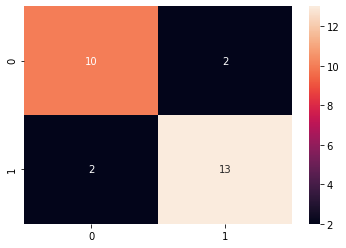

In [81]:
sns.heatmap(cm, annot=True, fmt='g')

### Multionomial Naive Bayes classifier

In [82]:
nb = MultinomialNB()
nb.fit(X_train_enc, y_train)
nb_pred = nb.predict(X_test_enc)
print("Accuracy", accuracy_score(nb_pred, y_test))

Accuracy 0.7777777777777778


In [83]:
cm = confusion_matrix(y_test, nb_pred)
print(cm)
report = classification_report(y_test, nb_pred)
print (report)

[[ 8  4]
 [ 2 13]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.76      0.87      0.81        15

    accuracy                           0.78        27
   macro avg       0.78      0.77      0.77        27
weighted avg       0.78      0.78      0.77        27



Conclusion:

RandomForest method gives the best predictions on this dataset with good confusion matrix and high scores in accuracy, precision, recall and f1 score for either of the methods used: Bag of words (BoW) & Ordinal Encoding.

Random forest model with BoW gives the best results among all models above.